In [79]:
# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 1
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plotting settings
size=35
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

Autosaving every 1 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Accessing files

Every file under any folder in ./data is parsed and put into dictionaries that group videos of the same source.
Videos of the same source are considered videos coming from the same Subject, same Session, same OD/OS, same (x, y),
same type (Confocal, OA790, OA850).

The parsing is case insensitive with the following rules:

**unmarked videos**:
must not contain 'mask' or '_marked'

**marked videos**:
Must end with '_marked.\<<file_extension\>>'

**standard deviation images**:
Must end with
'_std.\<<file_extension\>>'

**vessel mask images**: 
Must end with
'_vessel_mask.\<<file_extension\>>'

**channel type**:
must contain one of 'OA790', 'OA850', 'Confocal' (case insensitive)

### Example to using dictionaries that relate video of the OA790 channel that have marked videos 
(useful for training and training)

In [80]:
from sharedvariables import get_video_file_dictionaries
from os.path import basename

# video_type must be one of 'oa790', 'oa850', 'confocal'
video_file_oa790_dictionaries = get_video_file_dictionaries(channel_type='oa790', should_have_marked_video=True)
for video_dict in video_file_oa790_dictionaries:
        assert video_dict['has_marked_video']
        print('-----------------------')
        print('Video file:', basename(video_dict['video_file']))
        print('Does video have a corresponding marked video?:', video_dict['has_marked_video'])
        print('Channel type:', video_dict['type'])
        print('Subject number:', video_dict['subject_number'])
        print('Session number:', video_dict['session_number'])
        print('Marked Video OA790:', basename(video_dict['marked_video_oa790_file']))
        print('Marked Video OA850:', basename(video_dict['marked_video_oa850_file']))
        print('Std dev image confocal:', basename(video_dict['std_image_confocal_file']))
        print('Std dev image OA790:', basename(video_dict['std_image_oa790_file']))
        print('Std dev image confocal:', basename(video_dict['std_image_oa850_file']))
        print('Vessel mask OA790:', basename(video_dict['vessel_mask_oa790_file']))
        print('Vessel mask OA850:', basename(video_dict['vessel_mask_oa850_file']))
        print('Vessel mask confocal:', basename(video_dict['vessel_mask_confocal_file']))
        print()

-----------------------
Video file: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped.avi
Does video have a corresponding marked video?: True
Channel type: oa790
Subject number: 25
Session number: 298
Marked Video OA790: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped_marked.avi
Marked Video OA850: 
Std dev image confocal: Subject25_Session298_OD_(-2,0)_1.03x1_1642_Confocal_dewarped1_extract_reg_std.tif
Std dev image OA790: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_std.tif
Std dev image confocal: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA850nm_dewarped1_extract_reg_std.tif
Vessel mask OA790: 
Vessel mask OA850: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA850nm_vessel_mask.JPEG
Vessel mask confocal: Subject25_Session298_OD_(-2,0)_1.03x1_1642_Confocal_vessel_mask.jpg

-----------------------
Video file: Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped.avi
Does vide

# Reading frames from videos

Need to read only first channel because all the channels are the same

In [87]:
video_dict = video_file_oa790_dictionaries[0]

from videoutils import get_frames_from_video
import numpy as np

frames = get_frames_from_video(video_dict['video_file'])

print('frame shape (n_frames x H x W x C)', frames.shape)

# All channels are equal so we only need to use first channel
assert np.array_equal(frames[..., 0], frames[..., 1]) and np.array_equal(frames[..., 1], frames[..., 2])

frames = frames[..., 0]
print('Final frame shape', frames.shape)

# read marked frames

if video_dict['has_marked_video']:
    marked_frames = get_frames_from_video(video_dict['marked_video_oa790_file'])[..., 0]
    print('Marked video frames shape:',  marked_video_frames.shape)

frame shape (n_frames x H x W x C) (43, 576, 564, 3)
Final frame shape (43, 576, 564)
Marked video frames shape: (43, 576, 564)


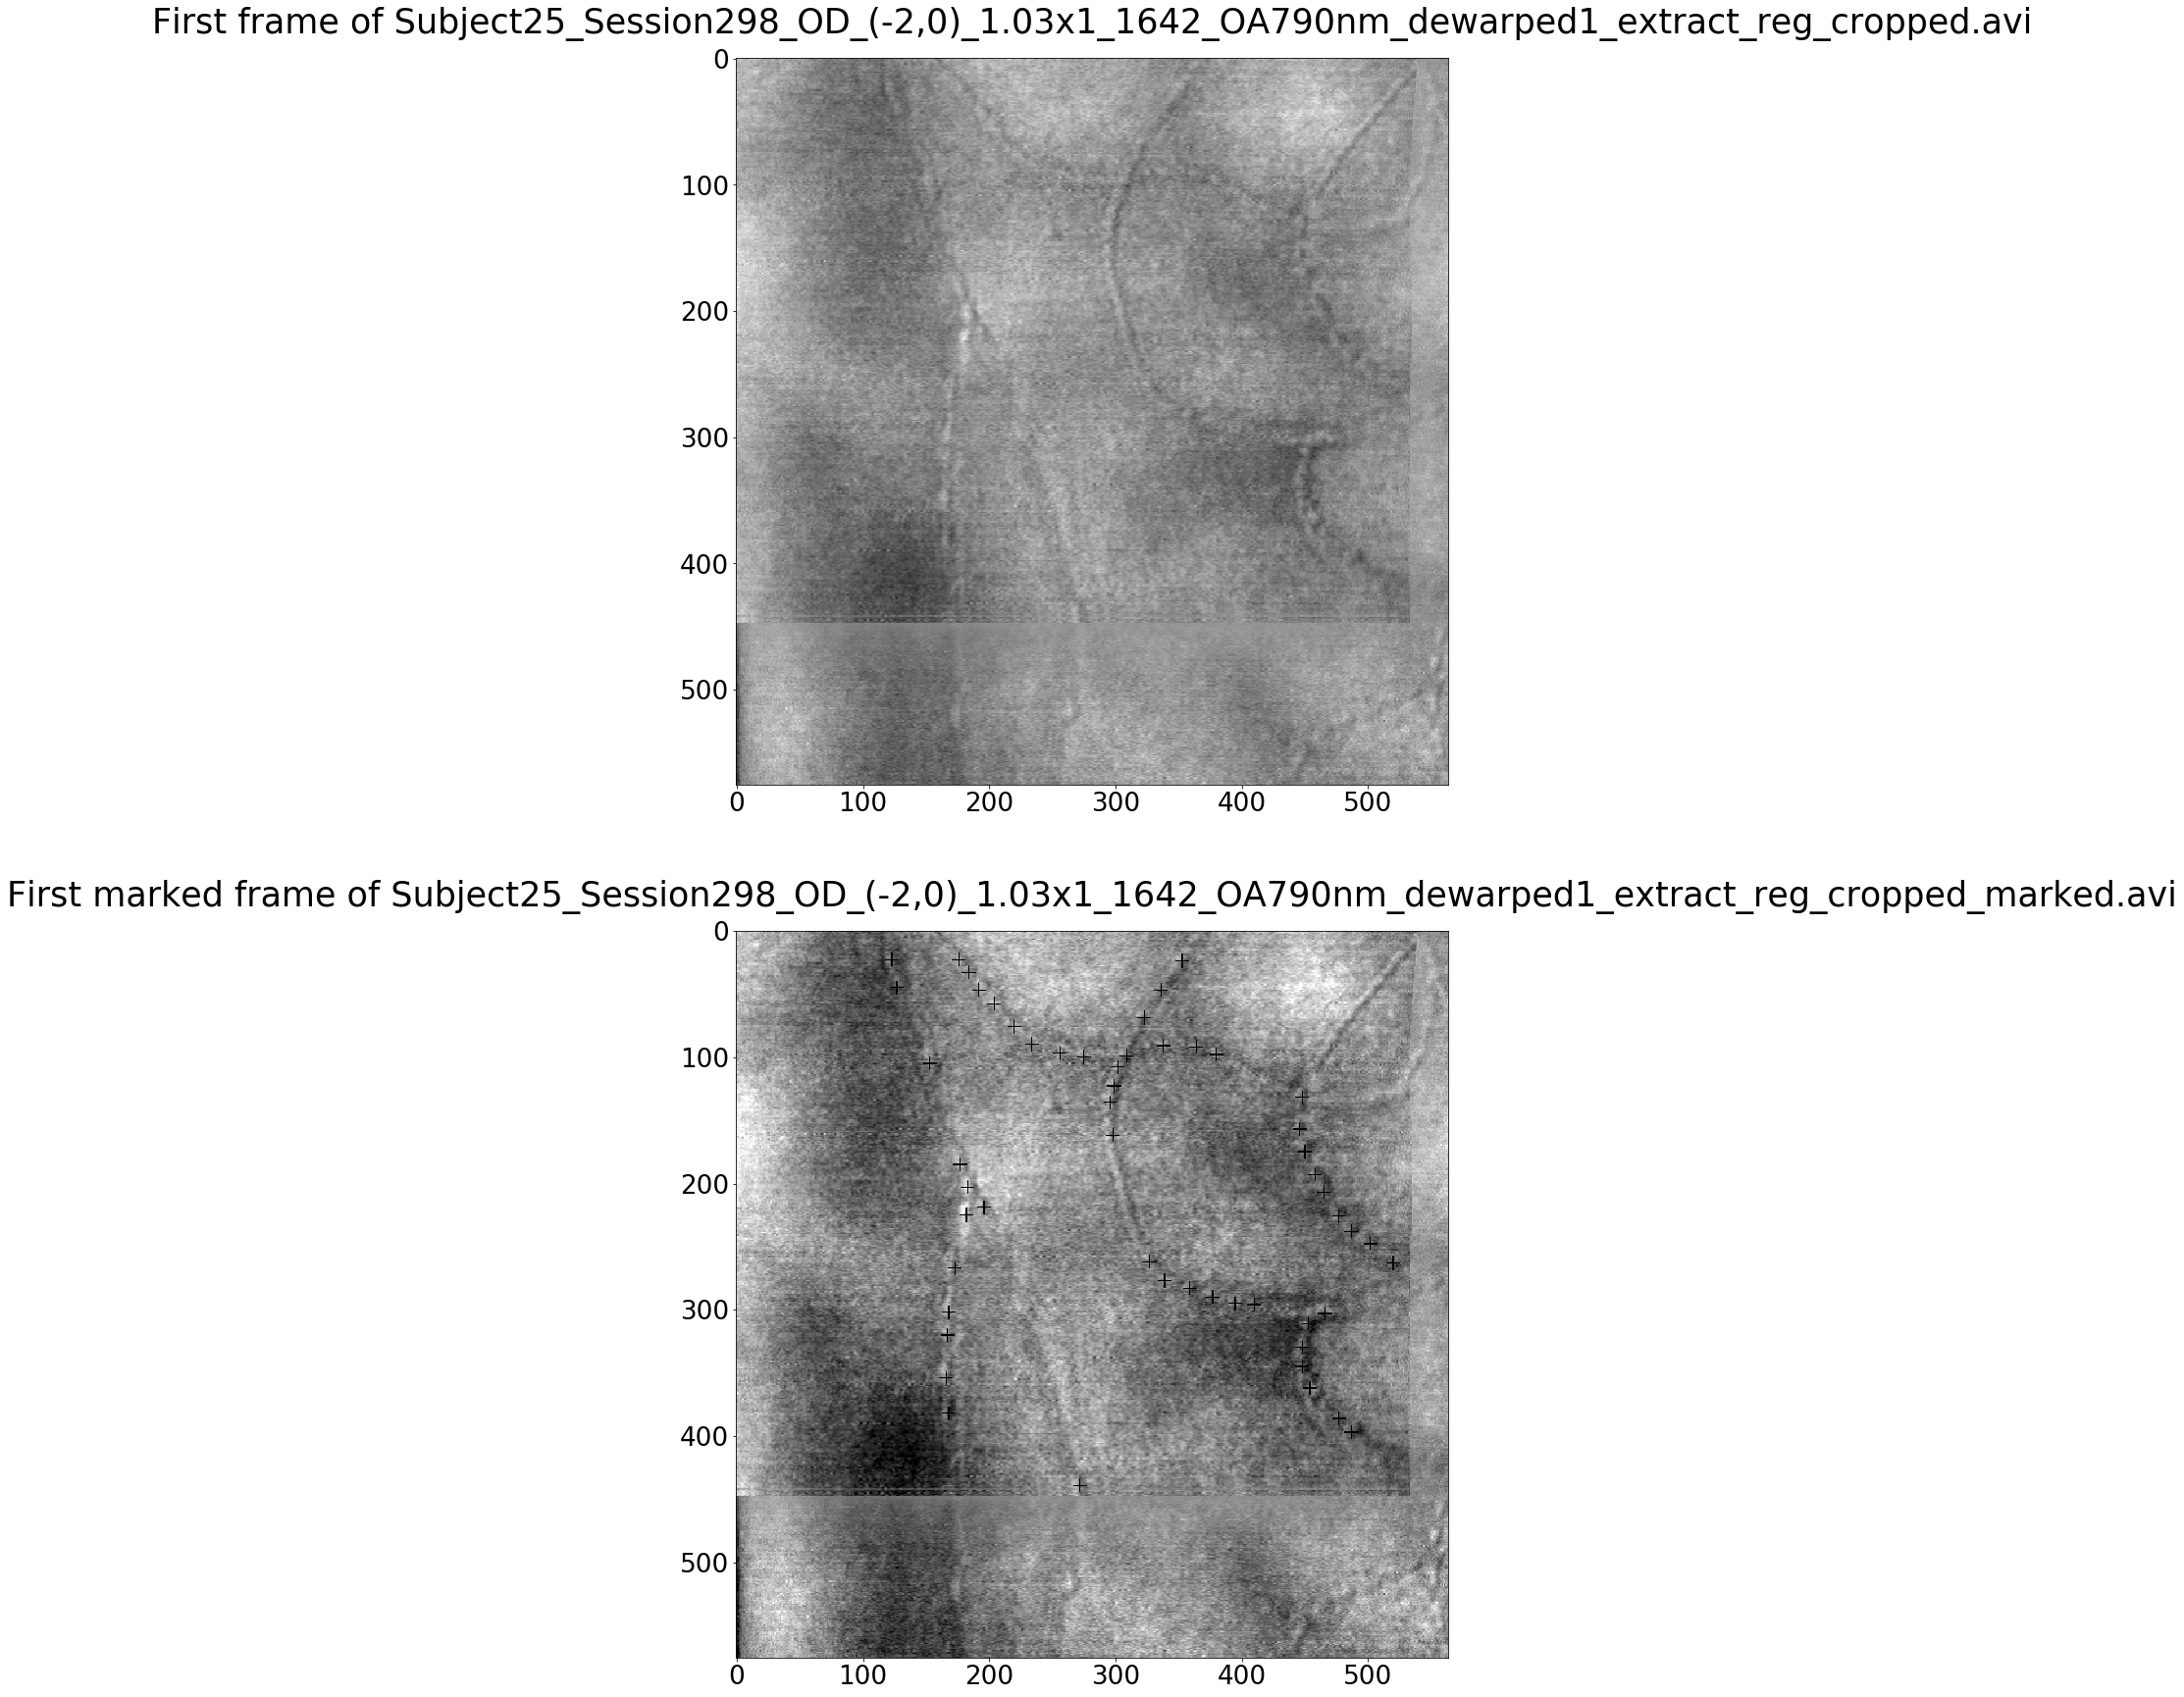

In [105]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(2, 1, figsize=(30, 30))
axes[0].imshow(frames[0], cmap='gray')
axes[0].set_title(f"First frame of {basename(video_dict['video_file'])}")
                  
axes[1].imshow(marked_frames[0], cmap='gray')
axes[1].set_title(f"First marked frame of {basename(video_dict['marked_video_oa790_file'])}")
pass

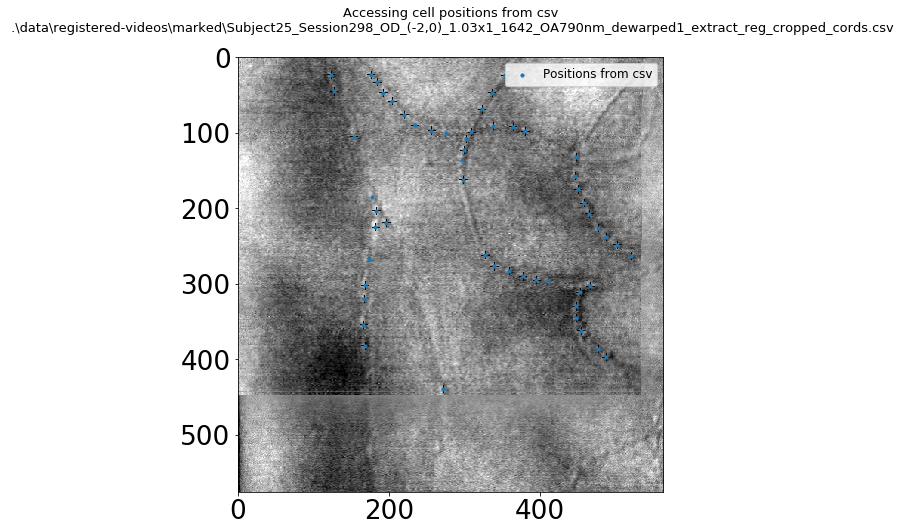

In [104]:
from generate_datasets import get_positions_from_csv

# When accessing the csvs with cell positions there can be many csvs for that file so it's a list
cell_positions = get_positions_from_csv(video_dict['cell_position_csv_files'][0], frame_idx=1)

# Notice how python is 0-indexed while the csv file is 1 indexed, hence frame_idx is 1 instead of 0
plt.imshow(marked_frames[0], cmap='gray')
plt.scatter(cell_positions[..., 0], cell_positions[..., 1], s=10, label='Positions from csv')
plt.title(f'Accessing cell positions from csv\n {video_dict["cell_position_csv_files"][0]}', fontsize=13)
plt.legend()
pass

### How to extract patches

In [113]:
print(cell_positions[:, 1].max(), marked_frames[0].shape)

439 (576, 564)


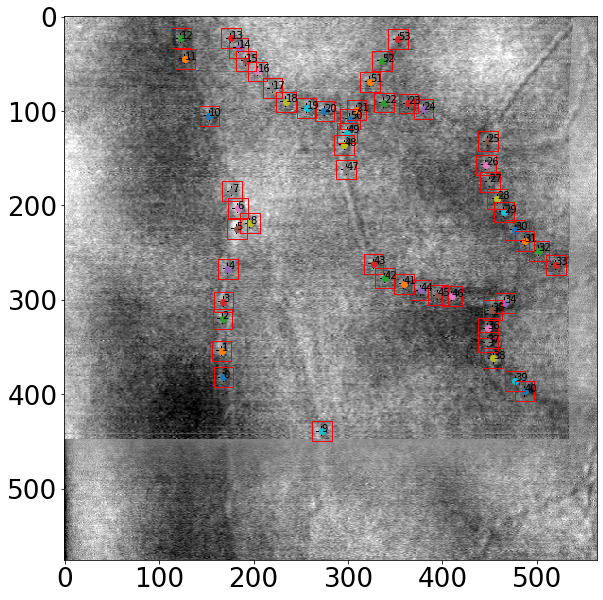

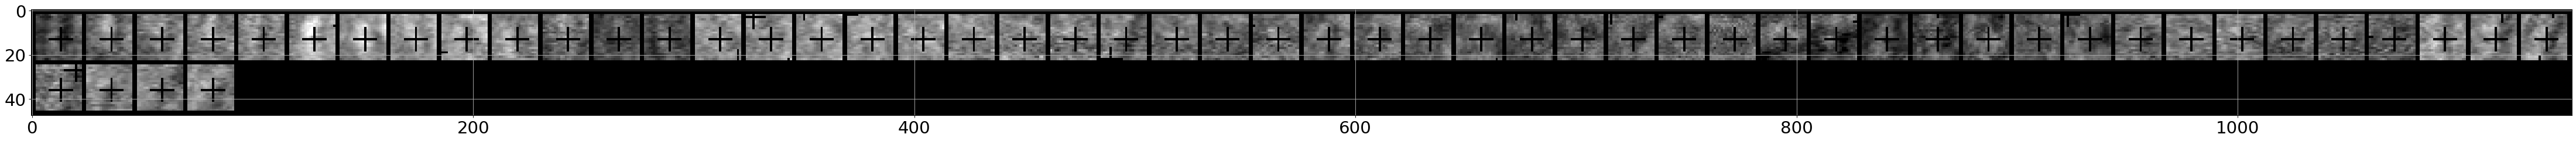

In [120]:
from patchextraction import extract_patches_at_positions
from plotutils import plot_images_as_grid

cell_patches = extract_patches_at_positions(marked_frames[0], cell_positions, visualize_patches=True)
plot_images_as_grid(cell_patches)